**Задание Ultra Pro**

Выгрузите какой-нибудь из ваших диалогов любой соц.сети и напишите нейронную сеть для классификации собеседника по сообщению. 

Использование групповых чатов для обучения поощряется, но усложняет задачу. Если необходима конфиденциальность, датасет можно не предоставлять. 

**Ссылка на гугл диск, где лежат файлы (Обучающие и тестовые)**
https://drive.google.com/drive/folders/1kEOMHDTKK_KbBFttWaubftlO8Qy3EWFB?usp=sharing

In [ ]:
# Для начала работы подключим все необходимые библиотеки
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SpatialDropout1D, BatchNormalization, Flatten, Embedding, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from google.colab import drive
import numpy as np
import os
import time
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline


# В первую очередь подготовим данные

In [ ]:
# Создадим функцию для первоначальной обработки файла
def readText(fileName):
  op = open(fileName, 'r')        # Указываем что открытие будет в режиме чтения
  text = op.read()                # Читаем файл с текстом
  text = text.replace("\n", " ")  # Заменям переносы строк на пробелы
  return text                     # Возвращаем измененный файл

In [ ]:
# Объявим классы. Запишем в список
className = ["Юля", "Елена"]
nClasses = len(className)

# Подсчитаем кол-во нужных нам классов
len(className)

2

# Загрузим обучающие тексты

In [ ]:
# Создадим 2 пустых списка (обучающий и проверочный), для последующего заполнения

trainText = []
testText = []

In [ ]:
# Пройдемся двумя циклами для заполнения списков. Так чтобы каждый i элемент в обучающей выборке соответствовал j элементу в тестовой.

for i in className:                                  # Проходим по каждому классу из списка ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"
  for j in os.listdir('/content/'):                     # Вторым циклом проходим по каждому файлу из папки texts
    if i in j:                                       # Если класс из списка содержится в папке texts, тогда
      if 'Обучающая' in j:                           # Если в имени файла содержится данное слово "Обучающая", то 
        trainText.append(readText('/content/' +j))      # Добавить в обучающую выборку
        print (j, 'добавлен в обучающую выборку')    # Проверим добавился или нет
      if 'Тестовая' in j:                            # Если в имени файла содержится данное слово "Тестовая", то 
        testText.append(readText('/content/' +j))       # Добавить в тестовую выборку
        print (j, 'добавлен в тестовую выборку')     # Проверим добавился или нет
  print ()                                           # Для разделения до   

(Юля) Тестовая.txt добавлен в тестовую выборку
(Юля ) Обучающая.txt добавлен в обучающую выборку

(Елена ) Обучающая.txt добавлен в обучающую выборку
(Елена) Тестовая.txt добавлен в тестовую выборку



In [ ]:
# Посмотрим на результат работы
# Длина списка
print ("Длина списка trainText: ",len(trainText))

# Так же например узнать кол-во символов в одном из обучающих текстов
print ("Количество символов ",len(trainText[1]))
print ("Количество символов ",len(testText[1]))


Длина списка trainText:  2
Количество символов  101631
Количество символов  46689


# Обработка данных. Преобразование в числовые векторы

In [ ]:
cur_time = time.time()   # Засекаем время начала (текущее)
maxWordsCount = 6700    # Зададим максимальное кол-во слов/индексов при обучении

# C помощью функции Tokenizer разобъем текст и превратим в матрицу числовых значений
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token ='unknow', char_level = False)

tokenizer.fit_on_texts(trainText)     # Обрабатываем методом fit_on_texts подготовленный обучающий список trainText

# Для просмотра нужно вытащить индексы слов c помощью метода word_index.items и сделать из него список
items = list(tokenizer.word_index.items())

# Посотрим сколько потребуется времени для выполнения данного кода
print ("Время обработки:", round(time.time() - cur_time, 2), 'c')

Время обработки: 0.04 c


In [ ]:
# Посмотрим на результат.
# 10 самых часто встречающихся слов:
print (items[:10])

[('unknow', 1), ('и', 2), ('в', 3), ('не', 4), ('а', 5), ('на', 6), ('с', 7), ('у', 8), ('я', 9), ('что', 10)]


In [ ]:
# И 10 самых редких слов 
print (items[-10:])

[('полетим', 6692), ('кнопочки', 6693), ('выбираем', 6694), ('аэропорту', 6695), ('понянькаться', 6696), ('экскурсии', 6697), ('поездить', 6698), ('переносят', 6699), ('закладывает', 6700), ('приноровились', 6701)]


In [ ]:
# Размер словаря.
len(items)

6701

In [ ]:
# Чтобы узнать индекс интересующего слова в словаре, можно воспользоваться методом word_index

#print ("Имеет индекс: ", tokenizer.word_index[input("Слово: ")])

In [ ]:
# Теперь согласно частотному словарю можно преобразовать текст в последовательность индексов

trainWordIndexes = tokenizer.texts_to_sequences(trainText)   # Обучающие в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)     # Проверочные в индексы

In [ ]:
# Посмотрим информацию об этих переменных. Тип и размер.
print (type(trainWordIndexes))   
print (type(testWordIndexes))   
print (len(trainWordIndexes))
print (len(testWordIndexes)) 
# trainWordIndexes и testWordIndexes являются списками (list)

<class 'list'>
<class 'list'>
2
2


In [ ]:
# Можно посмотреть как именно преобразовывается текст
print ("В оригинале:                   ", trainText[0][:40])
print ("В последовательности индексов: ", trainWordIndexes[0][:7])

В оригинале:                    А так с ребятами бегает "штабы" строят..
В последовательности индексов:  [5, 17, 7, 1746, 595, 3400, 1747]


# Собирем общую статистику

In [ ]:
# Перед подачей в нейронную сеть стоит убедиться что собранная база корректна. Для этого:

symbolsTrainText = 0 # Создадим счетчик для подстчета символов в обучающих текстах
wordsTrainText = 0   # Так же счетчик слов

# Пройдемся циклом по всем классам
print ("Общая статистика по обучающим текстам:\n")

for i in range(nClasses):
    print (className[i], ' '*(10-len(className[i])), len(trainText[i]), "символов и", len(trainWordIndexes[i]), "слов")
    symbolsTrainText += len(trainText[i])       # Общее кол-во символов
    wordsTrainText += len(trainWordIndexes[i])  # Общее кол-во слов

print("\nВ сумме ", symbolsTrainText, "символов и ", wordsTrainText, "слов\n--------------------------------------------")


# Аналогично посмотрим по тестовым

print ("\nОбщая статистика по тестовым текстам:\n")

symbolsTestText = 0 
wordsTestText = 0

for i in range(nClasses):
    print (className[i], ' '*(10-len(className[i])), len(testText[i]), "символов и", len(testWordIndexes[i]), "слов")
    symbolsTestText += len(testText[i])       
    wordsTestText += len(testWordIndexes[i]) 
print("\nВ сумме ", symbolsTestText, "символов и ", wordsTestText, "слов")

# Видно что с такой базой можно работать. Нет перекоса. Можно приступать к созданию выборок (обучающей и проверочной)



Общая статистика по обучающим текстам:

Юля         99961 символов и 16504 слов
Елена       101631 символов и 16842 слов

В сумме  201592 символов и  33346 слов
--------------------------------------------

Общая статистика по тестовым текстам:

Юля         48234 символов и 8127 слов
Елена       46689 символов и 7575 слов

В сумме  94923 символов и  15702 слов


# Создание обучающей и проверочной выборок

In [ ]:
# Для начала создадим функции. 
# Первая для разделения на короткие векторы с заданным шагом и размером

def getSetFromIndexes (wordIndexes, xLen, step):     # В качестве аргументов принимает (trainWordIndexes или testWordIndexes - список, размер и шаг) 
  xSample = []                                        # Созадим пустой спискок для хранения векторов
  wordsLen = len(wordIndexes)                         # Кол-во слов в поданных на вход trainWordIndexes или testWordIndexes
  index = 0                                           # Начальный индекс (с помощью этой переменной будем сдвигать шаг)


  while (index + xLen <= wordsLen):                   # Задаем цикл пока не дойдем до конца    
    xSample.append(wordIndexes[index:index + xLen])   # На каждой итерации добавляем в список кусок вектора заданной длины
    index += step                                     # Смещаемся на шаг

  return xSample

In [ ]:
# Вторая функция для формирования обучающей и проверочной выборок

def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)                            # Зададим кол-во классов выборки
  classesXSample = []                                    # Создадим пустой список в котором будут храниться список нарезанных кусочков предыдущей функцией getSetFromIndexes

  # Пройдемся циклом по каждому тексту выборки из последовательнстей индексов
  for i in wordIndexes:
    classesXSample.append(getSetFromIndexes(i, xLen, step))
  
  # Сформируем один общий список
  xSamples = []                                           # Создаем пустые списки
  ySamples = []

  for t in range(nClasses):                               # В нашем случаи цикл от 0 до 6 (кол-во классов)
    xT = classesXSample[t]                                # На каждой итерации цикла берем очередной нарезанный текст одного из класса

    for i in range (len(xT)):                             # Циклом проходимся по каждому его окну
      xSamples.append(xT[i])                              # Добавляем в общий список обучающей выборке
      ySamples.append(utils.to_categorical(t, nClasses))  # И соответствующий вектор класса
  
  # Переводим в numpy массив
  xSamples = np.array(xSamples)                           
  ySamples = np.array(ySamples)    

  # B возвращаем выборки
  return (xSamples, ySamples)

In [ ]:
# Создадим еще одну функцию которая будет распознавать тестовую выборку и выводить результаты
def recognizerMultiClass (model, xTest, modelName):
  print ("Название нейронной сети: ", modelName)        # Для наглядности выведем название сети
  print ()                                              # Пропустим стороку
  totalSumRec = 0                                       # Создадим счетчик суммы правильных ответов

  # Пройдемся циклом по всем классам
  for i in range(nClasses):                             # От 0 до 6 
    currPred = model.predict(xTest[i])                  # Получим результаты распознования класса по блокам слов длинны xLen.
    currOut = np.argmax(currPred, axis=1)               # Определим номер распознанного класса с помощью функции argmax
    evVal = []
    
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec +=len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal)                  # Определяем какой класс за какой был распознан в итоге

    # И выводим результаты

    isRecognized = "Ответ НЕВЕРНЫЙ, УВЫ"
    if (recognizedClass == i):
      isRecognized = "УРА, ответ ВЕРНЫЙ!"
    
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть предсказала: " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')

  # Выведим средний процент распознавания 
  print ()                                                                          # Пустая строка чтобы отделить
  sumCount = 0
  # Пройдемся циклом по всем циклам
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print ("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%")
  print ()                                                                          # Пустая строка чтобы отделить

  return totalSumRec/sumCount

In [ ]:
# Создадим функцию которая будет представлять выборку в удобном для распознавания размерах

def createTestMultiClasses(wordIndexes, xLen, step):

  # Создаем тестовую выборку из индексов для каждого из 6 классов
  nClasses = len(wordIndexes)                                             # Переменной nClasses присвоим кол-во классов
  xTest6ClassesBow = []                                                   # Создадим пустой список, в котором будут список из всех классов
  xTest6Classec = []                                                      # Создадим список массивов

  # Пройдемся циклом по каждому тестовому тексту из последовательности индексов
  for i in wordIndexes:
    sample = (getSetFromIndexes(i,xLen, step))                            # Воспользуемся ранее написанной функцией для нарезки на векторы
    xTest6Classec.append(sample)                                          # Добавляем в список на каждой итерации 
    xTest6ClassesBow.append(tokenizer.sequences_to_matrix(sample))        # Трансформируем в BOW
  
  xTest6ClassesBow = np.array(xTest6ClassesBow)                           # Переводим в numpy массив
  xTest6Classec = np.array(xTest6Classec)                                 # Переводим в numpy массив

  return xTest6ClassesBow, xTest6Classec

In [ ]:
# Преобразуем тестовую выборку
xTest6ClassesBow, x2 = createTestMultiClasses(testWordIndexes, xLen, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Подготовка данных

In [ ]:
# Установим базовые параметры
xLen = 200        # Длина отрезка текста на которые будет разбивать функция getSetFromIndexes
step = 20         # Шаг разбивания для той же функции

In [ ]:
# Можем посмотреть сколько займет времени подготовка данных
cur_time = time.time()

# Сформируем выборки (обучающую и тестовую)
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

# Посмотрим что в итоге получилось
print (xTrain.shape)
print (yTrain.shape)
print (xTest.shape)
print (yTest.shape)

print ("Время обработки:", round(time.time() - cur_time, 2), 'c')

(1649, 200)
(1649, 2)
(766, 200)
(766, 2)
Время обработки: 0.06 c


Для Embedding обучающие и тестовые наборы готовы, но для BOW нужно xTrain и yTrain представить в виде векторов из 0 и 1

In [ ]:
#cur_time = time.time()

# Преобразовываем в матрицы нулей и единиц по принципу BOW. xTrain и yTrain подаем в виду списка. 
xTrainBOW = tokenizer.sequences_to_matrix(xTrain.tolist())      
xTestBOW = tokenizer.sequences_to_matrix(xTest.tolist())      

# Посмотрим на размер обучающей выборки, сформированной по BOW
print (xTrainBOW.shape)
print (xTestBOW.shape)

#print ("Время обработки:", round(time.time() - cur_time, 2), 'c')

(1649, 6700)
(766, 6700)


# Создаем нейросеть для BOW

In [ ]:
# Создадим полносвязную сеть
modelBow = Sequential()
modelBow.add(Dense(300, input_dim=maxWordsCount, activation = 'relu'))     # input_dim = maxWordsCount = 20000  - входные данные
modelBow.add(Dropout(0.45))
modelBow.add(BatchNormalization())
modelBow.add(Dense(2, activation ='softmax'))

In [ ]:
# Скомпилируем ее
modelBow.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/30
17/17 [==============================] - 3s 17ms/step - loss: 0.3053 - accuracy: 0.8655 - val_loss: 0.3070 - val_accuracy: 0.8681
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 4.2772e-04 - accuracy: 1.0000 - val_loss: 0.2560 - val_accuracy: 0.9073
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 1.5410e-04 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9204
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 8.0668e-05 - accuracy: 1.0000 - val_loss: 0.2196 - val_accuracy: 0.9243
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 1.2355e-04 - accuracy: 1.0000 - val_loss: 0.2076 - val_accuracy: 0.9282
Epoch 6/30
17/17 [==============================] - 0s 8ms/step - loss: 5.5341e-05 - accuracy: 1.0000 - val_loss: 0.1962 - val_accuracy: 0.9321
Epoch 7/30
17/17 [==============================] - 0s 7ms/step - loss: 6.6714e-05 - accuracy: 1.0000 - val_loss: 0.1857 - val_accuracy: 0.

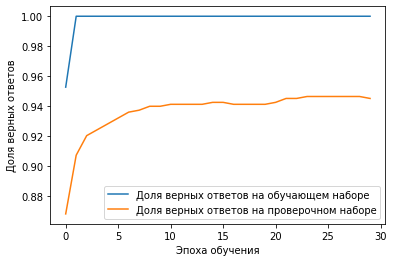

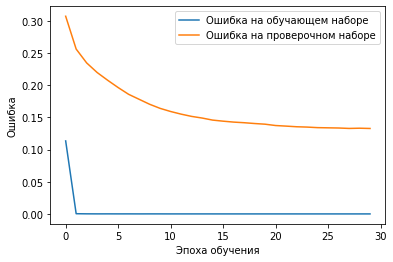

In [ ]:
# Обучаем сеть на выборке, xTrainBOW

history = modelBow.fit(xTrainBOW, yTrain, epochs=30, batch_size = 100, validation_data=(xTestBOW, yTest))


# Посмотрим на график обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


# График ошибок. На предмет переобучения сети.
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show() 

# При таких значениях гиперпараметрах сети на проверочной выборке удалось добиться точности больше 90% 

In [ ]:
# Сохраним веса
modelBow.save_weights('modelBow - loss: 1.5512e-05 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9034.h5')

# Распознавание проверочной выборки

In [ ]:
# Проверим точность сети на BOW
pred = recognizerMultiClass (modelBow, xTest6ClassesBow, "BOW: Dense-DropOut-BatchNormalization-Dense")

Название нейронной сети:  BOW: Dense-DropOut-BatchNormalization-Dense

Класс: Юля        98% сеть предсказала: Юля            УРА, ответ ВЕРНЫЙ!
Класс: Елена      89% сеть предсказала: Елена          УРА, ответ ВЕРНЫЙ!

Средний процент распознавания  94 %



Нейронная сеть обученная на Bag of Words показала хороший результат

# Нейронная сеть с Embedding - relu

In [ ]:
# Создаем нейронную сеть со слоем Embedding  и activation='softmax'
modelEmb_1 = Sequential()

modelEmb_1.add(Embedding(maxWordsCount,10, input_length=xLen))       # maxWordsCount = 20000
modelEmb_1.add(SpatialDropout1D(0.4))

modelEmb_1.add(Flatten())
modelEmb_1.add(BatchNormalization())

modelEmb_1.add(Dense(50, activation="relu"))
modelEmb_1.add(Dropout(0.4))
modelEmb_1.add(BatchNormalization())

modelEmb_1.add(Dense(2,activation='softmax'))

# Скомпилируем данную сеть
modelEmb_1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Обучим сеть на обучающей выборке xTrain
history = modelEmb_1.fit(xTrain, yTrain, epochs=30, batch_size=150, validation_data=(xTest, yTest))

Epoch 1/30
11/11 [==============================] - 1s 25ms/step - loss: 1.0197 - accuracy: 0.5057 - val_loss: 0.6940 - val_accuracy: 0.4922
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 0.7497 - accuracy: 0.6232 - val_loss: 0.6918 - val_accuracy: 0.5444
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 0.5190 - accuracy: 0.7358 - val_loss: 0.6891 - val_accuracy: 0.5457
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 0.3232 - accuracy: 0.8589 - val_loss: 0.6857 - val_accuracy: 0.5561
Epoch 5/30
11/11 [==============================] - 0s 10ms/step - loss: 0.1944 - accuracy: 0.9326 - val_loss: 0.6812 - val_accuracy: 0.5313
Epoch 6/30
11/11 [==============================] - 0s 10ms/step - loss: 0.1061 - accuracy: 0.9788 - val_loss: 0.6746 - val_accuracy: 0.5457
Epoch 7/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0701 - accuracy: 0.9926 - val_loss: 0.6668 - val_accuracy: 0.5627
Epoch 8/30
11

In [ ]:
# Преобразуем тестовую выборку
_ , xtest2Classes = createTestMultiClasses(testWordIndexes, xLen, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
pred = recognizerMultiClass (modelEmb_1, xtest2Classes, "Embedding")

Название нейронной сети:  Embedding

Класс: Юля        92% сеть предсказала: Юля            УРА, ответ ВЕРНЫЙ!
Класс: Елена      63% сеть предсказала: Елена          УРА, ответ ВЕРНЫЙ!

Средний процент распознавания  78 %



# Нейронная сеть с Embedding sigmoid

*Посмотрим какие будут показатели у той же нейронной сети, только выходной слой с активацией* **sigmoid** 

In [ ]:
#  activation='sigmoid'
modelEmb_2 = Sequential()

modelEmb_2.add(Embedding(maxWordsCount, 10, input_length=xLen))       # maxWordsCount = 20000
modelEmb_2.add(SpatialDropout1D(0.4))

modelEmb_2.add(Flatten())
modelEmb_2.add(BatchNormalization())

modelEmb_2.add(Dense(50, activation="relu"))
modelEmb_2.add(Dropout(0.4))
modelEmb_2.add(BatchNormalization())

modelEmb_2.add(Dense(2,activation='sigmoid'))

# Скомпилируем данную сеть
modelEmb_2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/30
11/11 [==============================] - 1s 25ms/step - loss: 1.0445 - accuracy: 0.5182 - val_loss: 0.6938 - val_accuracy: 0.4856
Epoch 2/30
11/11 [==============================] - 0s 11ms/step - loss: 0.7976 - accuracy: 0.6006 - val_loss: 0.6928 - val_accuracy: 0.4856
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 0.5046 - accuracy: 0.7483 - val_loss: 0.6899 - val_accuracy: 0.5026
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 0.2812 - accuracy: 0.8843 - val_loss: 0.6859 - val_accuracy: 0.5457
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.1594 - accuracy: 0.9432 - val_loss: 0.6804 - val_accuracy: 0.5627
Epoch 6/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0901 - accuracy: 0.9815 - val_loss: 0.6710 - val_accuracy: 0.6789
Epoch 7/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0588 - accuracy: 0.9908 - val_loss: 0.6601 - val_accuracy: 0.7480
Epoch 8/30
11

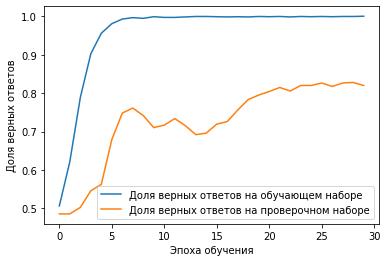

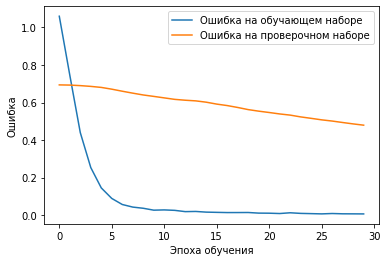

In [ ]:
# Обучим сеть на обучающей выборке xTrain
history = modelEmb_2.fit(xTrain, yTrain, epochs=30, batch_size=150, validation_data=(xTest, yTest))

# Посмотрим на график обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


# График ошибок. На предмет переобучения сети.
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show() 


# Проверим результаты Embedding сети

In [ ]:
# Преобразуем тестовую выборку
_, xtest2Classes = createTestMultiClasses(testWordIndexes, xLen, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
pred = recognizerMultiClass (modelEmb_2, xtest2Classes, "Embedding")

Название нейронной сети:  Embedding

Класс: Юля        88% сеть предсказала: Юля            УРА, ответ ВЕРНЫЙ!
Класс: Елена      74% сеть предсказала: Елена          УРА, ответ ВЕРНЫЙ!

Средний процент распознавания  81 %



# Выводы:

1. Как говорилось на лекции большой объем работы занимает сделать базу для обучения. Отредактировать сообщения, разделить и убрать все лишнее (даты, имя). Но зато хорошая практика.
2. Так же для лучшего обучения хорошо смотреть статистику(символов, слов) у каждого собеседника, чтобы не было перекоса в данных. (У одного значительно больше чем у другого) старался сделать ровно. 
3. Не смотря что первая нейронная сеть с **Bag of Words** дала хороший результат:

 Класс: Юля        **98%** сеть предсказала: Юля            УРА, ответ ВЕРНЫЙ!

 Класс: Елена      **89%**сеть предсказала: Елена          УРА, ответ ВЕРНЫЙ!

  Средний процент распознавания  **94 %**


4. Хотелось посомтреть как с этой задачей справится метод **Embedding**

- C активацией **"relu"**:

Класс: Юля        **92%** сеть предсказала: Юля            УРА, ответ ВЕРНЫЙ!

Класс: Елена      **63%** сеть предсказала: Елена          УРА, ответ ВЕРНЫЙ!

Средний процент распознавания  **78 %**

- C активацией **"sigmoid"**:

Класс: Юля        **88%** сеть предсказала: Юля            УРА, ответ ВЕРНЫЙ!

Класс: Елена      **74%** сеть предсказала: Елена          УРА, ответ ВЕРНЫЙ!

Средний процент распознавания  **81 %**

5. C данной задачей метод BAG справился лучше, но это не значит, что не стоит проовать другие способы, например Embedding(нужно проводить множество экспериментов, чтобы удостовериться в правильности выбора модели нейронной сети и способа обучения)

6. Чтобы добиться данного результата было перепробовано много вариантов подбора гиперпараметров. Можно продолжить дальше подбирать лучшую архитектуру и гиперпараметры, чтобы повысить точность как c BAG так и c Embedding. 

7. Было интересно делать эту работу, так как стиль у двух собеседников и темы примерно одинаковые, тем неменее нейронная сеть хорошо справилась с поставленной ей задачей.